## Step 0: Read in packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math

from astropy.utils.data import download_file
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve_fft

import scipy.misc as s
import imageio
import scipy
import scipy.ndimage as ndimage

%matplotlib inline
from scipy import stats


# Part 1: Making an image less blurry

## Step 1: Open Image

In [3]:
plt.style.use('default')
hdulist = fits.open('eagle.fits')
hdu = hdulist[0]

## Step 2: Plot histogram which allows me to evaluate the range of the data to help me better visualize it later. (```vmin``` and ```vmax```)

/Users/candicestauffer/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


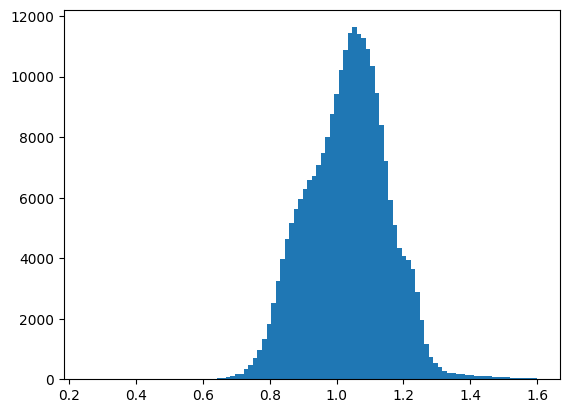

In [4]:
#taking a section of the acutal image
no_trim_log_data = np.log10(hdu.data+1E-3)[50:790]
#I will record in log since this will be easier to plot
log_data = no_trim_log_data[100:600, 650:1150] 
plt.hist(log_data.flatten(), range=(.25, 1.6), bins=100);
#hdu.header

## Step 3: Plot the image.

/Users/candicestauffer/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
  
/Users/candicestauffer/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "vmin" which is no longer supported as of 3.3 and will become an error two minor releases later
  
/Users/candicestauffer/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "cmap" which is no longer supported as of 3.3 and will become an error two minor releases later
  


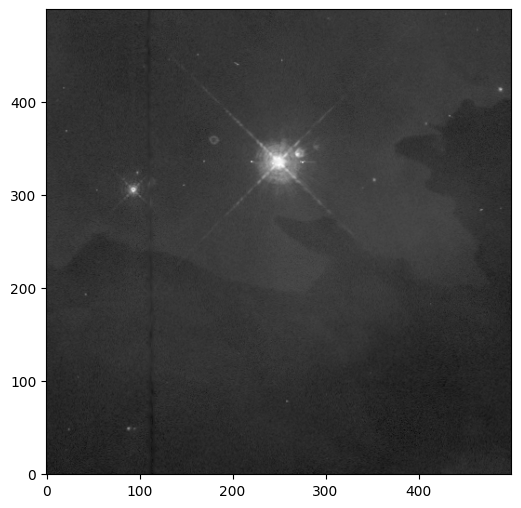

In [5]:

fig = plt.figure(figsize=(6,12))
fig.add_subplot(111)

#Notice vmin and vmax correspond to the rnage of the dta
plt.imshow(log_data, origin='lower',cmap = "gray")
plt.savefig('original.png',type='png',vmin=0,cmap = "gray")


## Step 4: Convert to sky coordinates instead of cm. This analysis can be done without this step.

In [192]:
# distance to the object
dist_obj = 5.3691e21 #cm
ra_obj = '8h18m48s'
dec_obj = '+13d49m02.096s'

In [193]:
w = WCS(naxis=2)

cdelt1 = ((hdu.header['CD1_1']/dist_obj*u.rad).to('deg'))
cdelt2 = ((hdu.header['CD2_2']/dist_obj*u.rad).to('deg'))

print(cdelt1, cdelt2)
          
# reference pixel coordinate
w.wcs.crpix = [log_data.shape[0]/2,log_data.shape[1]/2]

# sizes of the pixel (deg)
w.wcs.cdelt = [-cdelt1.base, cdelt2.base]

# ra and da to degrees 
c = SkyCoord(ra_obj, dec_obj)
w.wcs.crval = [c.ra.deg, c.dec.deg]

#axes units
w.wcs.cunit = ['deg', 'deg']

#update header
wcs_header = w.to_header()
hdu.header.update(wcs_header)
wcs = WCS(hdu.header)

2.0041015956250072e-25 deg -2.005913598262567e-25 deg


Changed DATE-OBS from ' 1/04/95          ' to '1995-04-01''. [astropy.wcs.wcs]


## Step 5: Plot same image with sky coords

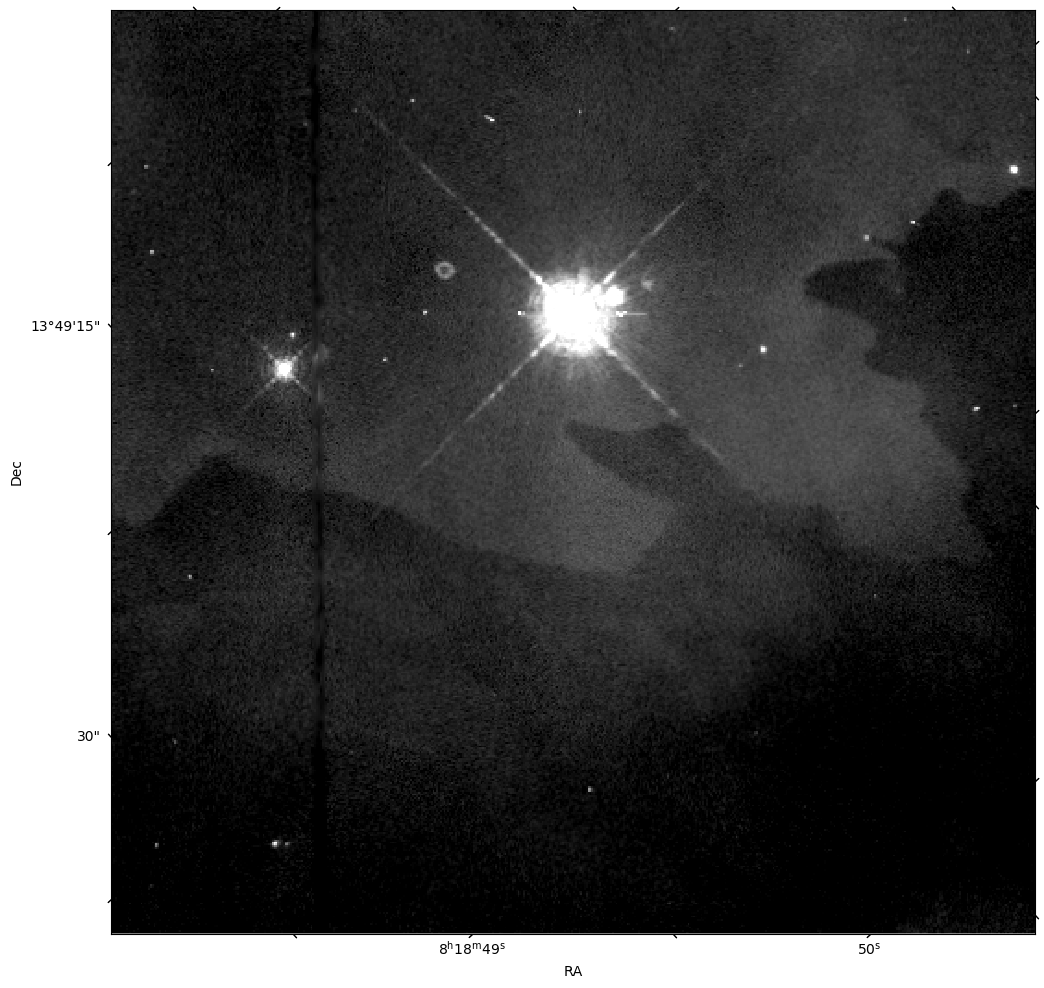

In [194]:
plt.style.use('default')

fig = plt.figure(figsize=(12,12))
fig.add_subplot(111, projection=wcs)
plt.imshow(log_data,vmin=.9,vmax=2, origin='lower',cmap = "gray")
plt.xlabel('RA')
plt.ylabel('Dec')
#plt.savefig('OGimage.pdf',style='pdf')

## Step 6: Create a point-spread function (with built in functions) 

Maybe your PSF is more complicated. Here's an alternative way to do this, using a 2D Lorentzian

81


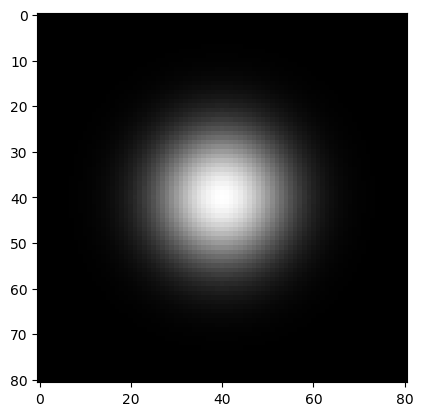

In [195]:
sigma = 10
psf = Gaussian2DKernel(sigma)
plt.imshow(psf.array,cmap = "gray")
print (len(psf.array))

## Step 7: Deblur the clear image with the point spread function. This will be deblured or deconvolved later manually later. 

In [196]:
convolved_image = convolve_fft(log_data,psf, boundary='wrap')


Step 8: Plot blurry image of orginal/. 

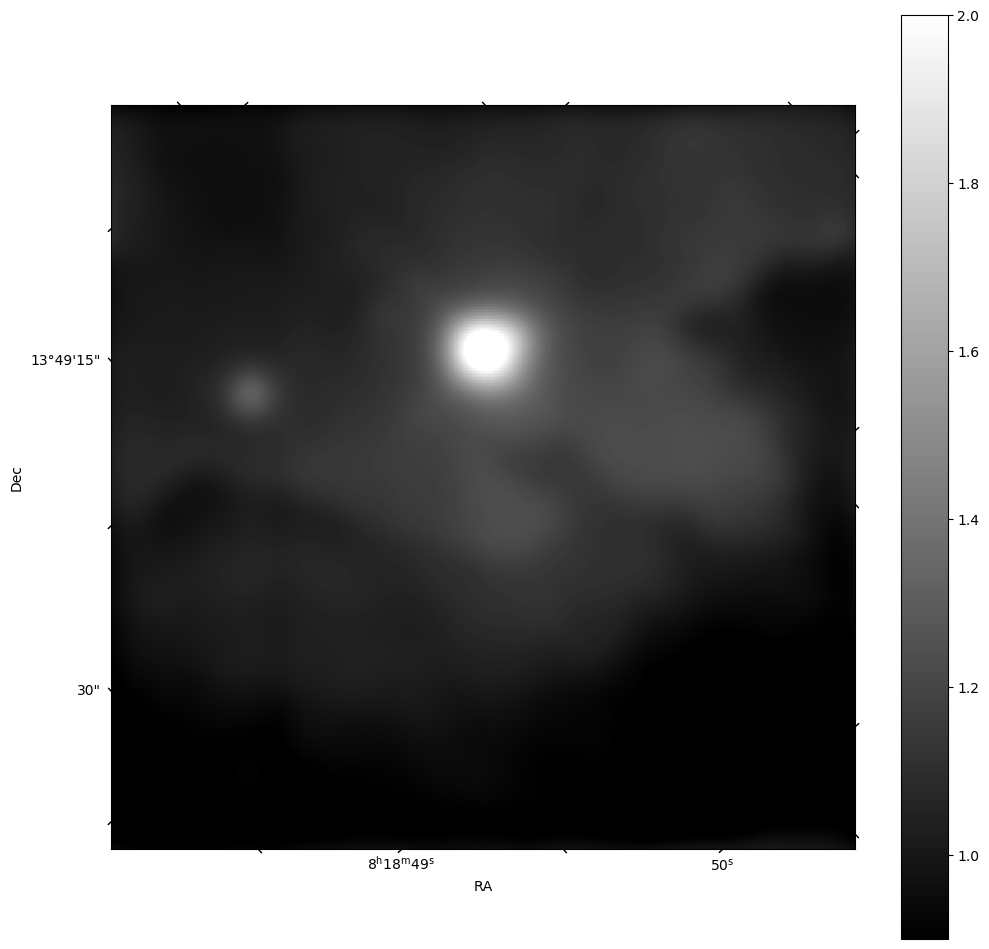

In [197]:
fig = plt.figure(figsize=(12,12))
fig.add_subplot(111, projection=wcs)
plt.imshow(convolved_image, origin='lower',vmin=.9,vmax=2,cmap = "gray")
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar() 
#plt.savefig('blurred_image.pdf',style='pdf')

## Step 9: Try to make the blurry image "sharper" to better identify the source.


In [198]:
def deconvolve(d, N, mu):
 
    height, width = d.shape
    kernel = np.zeros((height, width))
    
    for j in range(0, N):
        kernel[0, j]= 1/N
    
    #print (kernel)
    
    g = np.fft.fft2(d)
    
    
    
    h = np.fft.fft2(kernel) 
  
    
    square_h = h*h
    #Note that mu is here. h_hat is often zero so we add a small number to the denominator to get back valid answers
    g_h = (g/(abs(h)+mu))

    m = np.real(np.fft.ifft2(g_h))*convolved_image
    plt.figure(1)
    
    plt.imshow(m,origin='lower',cmap = "gray",vmin=.8,vmax=4)
    return m

## Step 10: Try and vary different values of L and mu

## Step 10aa: Vary L values

In [199]:
N = 5
mu = .001
L_5 = (deconvolve(convolved_image,N,mu))
plt.close()

In [200]:
N2= 15
mu2 = .001
L_15=deconvolve(convolved_image,N2,mu2)
plt.close()

In [201]:
N3 = 30
mu3 = .001
L_30 = deconvolve(convolved_image,N3,mu3)
plt.close()

In [202]:
N4 = 40
mu4 = .001
L_40 = deconvolve(convolved_image,N4,mu4)
plt.close()

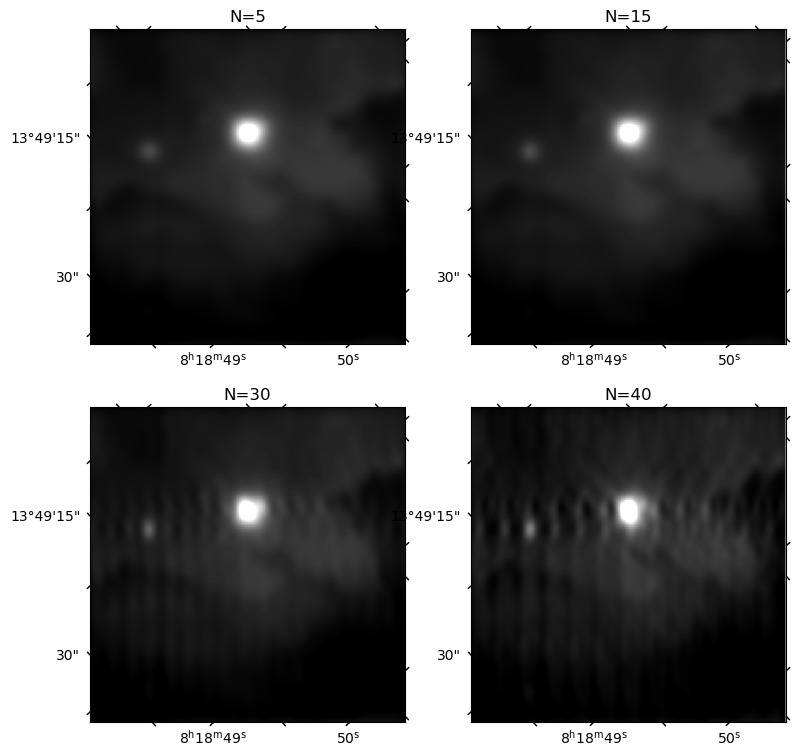

In [230]:
vmin=.8
vmax=4


fig = plt.figure(figsize=(9,9))
fig.add_subplot(221, projection=wcs)
plt.imshow(L_5,cmap = "gray",vmin=vmin,vmax=vmax)
plt.title('N=5')


fig.add_subplot(222, projection=wcs)
plt.imshow(L_15,cmap = "gray",vmin=vmin,vmax=vmax)
plt.title('N=15')


fig.add_subplot(223, projection=wcs)
plt.imshow(L_30,cmap = "gray",vmin=vmin,vmax=vmax)
plt.title('N=30')

fig.add_subplot(224, projection=wcs)
plt.imshow(L_40,cmap = "gray",vmin=vmin,vmax=vmax)
plt.title('N=40')
plt.savefig('Vary_L.pdf',style='pdf')

## Step 10ab: Determine which L value is the best by comparing the PDFs to that of the original image's pdf.

## Step 10ba: Vary $\mu$ Values

In [204]:
#d= imageio.imread('car.png')[:,:,1]
N= 30
mu = .1
mu_1= deconvolve(convolved_image,N,mu)
plt.close()

In [205]:
mu = .01
mu_01 = deconvolve(convolved_image,N,mu)
plt.close()

In [206]:
mu = .001
mu_001 = deconvolve(convolved_image,N,mu)
plt.close()

In [207]:
mu = .0001
mu_0001 = deconvolve(convolved_image,N,mu)
plt.close()

Text(0.5, 1.0, '$\\mu$=0.0001')

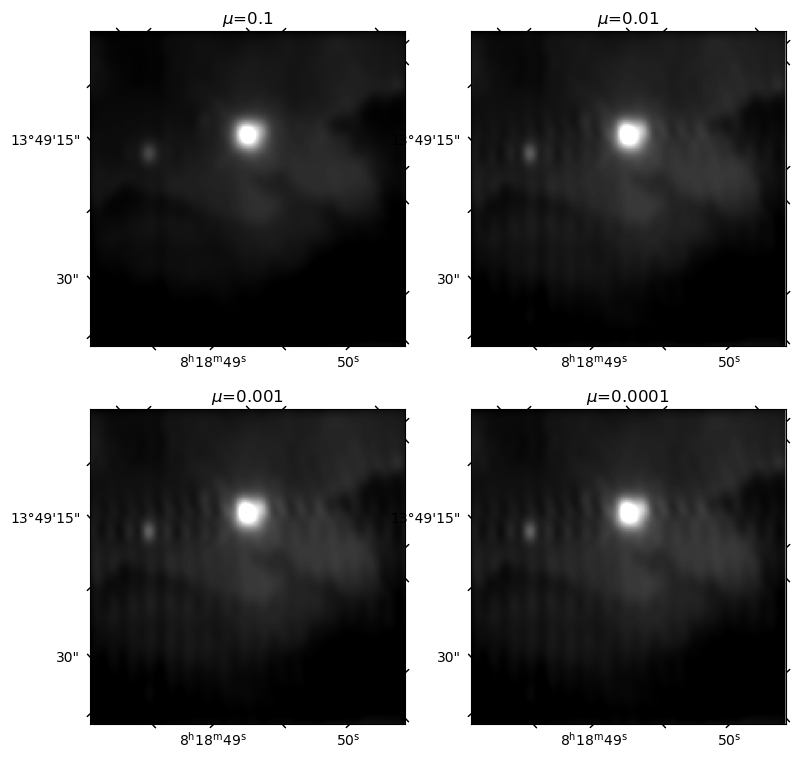

In [208]:
fig = plt.figure(figsize=(9,9))
fig.add_subplot(221, projection=wcs)
plt.imshow(mu_1,cmap = "gray",vmin=vmin,vmax=vmax)
plt.title('$\mu$=0.1')


fig.add_subplot(222, projection=wcs)
plt.imshow(mu_01,cmap = "gray",vmin=vmin,vmax=vmax)
plt.title('$\mu$=0.01')


fig.add_subplot(223, projection=wcs)
plt.imshow(mu_001,cmap = "gray",vmin=vmin,vmax=vmax)
plt.title('$\mu$=0.001')


fig.add_subplot(224, projection=wcs)
plt.imshow(mu_0001,cmap = "gray",vmin=vmin,vmax=vmax)
plt.title('$\mu$=0.0001')
#plt.savefig('Vary_mu.pdf',style='pdf')

## Step 10bb: Determine which value of $\mu$ is best

## Step 10c: Plot the image with best L and $\mu$ parameters

In [209]:
#Best parmaeters 
L_best = 30
mu = .001
fig = plt.figure(figsize=(6,6))
fig.add_subplot(111, projection=wcs)
best_image = deconvolve(convolved_image,L_best,mu)
plt.close()

In [210]:
#which data, what size square you want smoothed
def reduce_noise(data,square_size):
    idx = square_size //2 #since this is an index, we need to round to the closest number. In this case, I round down using '//'
    new_vals,new_d=[],[]
    new_d = np.zeros((len(data),len(data[0])))
  
    #Rows 
    for i in range(len(data)):
        #Columns
        for j in range(len(data[0])):
             
            #goes about accounting for how much we will smooth. Over what range we will smooth things out.
            for z in range(square_size):
                
                ##### Gets rid of points that are outside the range of the image
                #The point in a row + the iteration amount we smooth over, minus the smoothing parameter for half the grid
                a = i+z-idx
                #gets rid of points that are bigger or smaller than the grid itself 
                if a < 0 or a > len(data)-1:
                    for c in range(square_size):
                        new_vals.append(0)
                else:
                    #Column value + iteration amount we smooth over, minuse smooting aprameter of half the grid
                    b= j+z-idx
                     #gets rid of points that are bigger or smaller than the grid itself 
                    if b < 0 or j+idx > len(data[0]) - 1:
                        new_vals.append(0)
                        
                ##### Gives us back the actual noiseless points
                    else:
                        for k in range(square_size):
                            c = j+k -idx
                            new_vals.append(data[a][c])
                            
            new_vals.sort()
            new_d[i][j] = (new_vals[len(new_vals)//2])
            new_vals = []
    
    plt.imshow(new_d,origin='lower',cmap='gray',vmin=.8,vmax=2)
    return new_d

fig = plt.figure(figsize=(6,6))
fig.add_subplot(111, projection=wcs)

smoothed_best = reduce_noise(log_data,20)  #Greater value of square_size here takes a lot longer. Going any higher than 20 takes several minutes, but does result in better image.
plt.close()

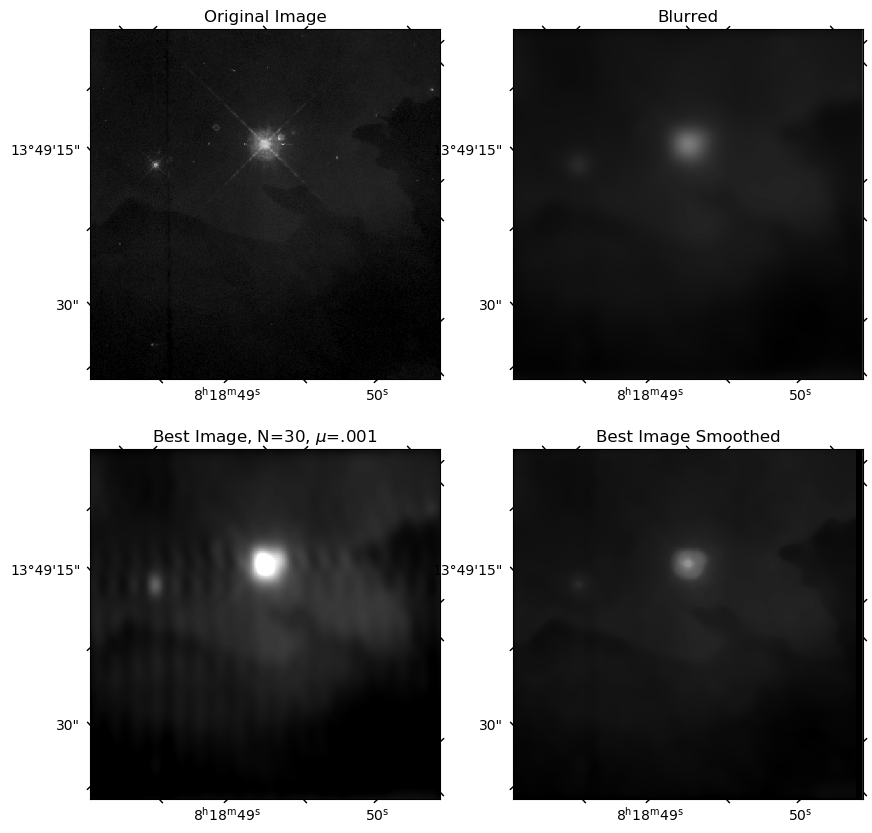

In [228]:
#plt.style.use('default')

vmin=.8
vmax=4
fig = plt.figure(figsize=(10,10))

fig.add_subplot(221, projection=wcs)
plt.imshow(log_data,cmap = "gray",vmin=vmin,vmax=vmax)
plt.title('Original Image')


fig.add_subplot(222, projection=wcs)
plt.imshow(convolved_image,cmap = "gray",vmin=vmin,vmax=vmax)
plt.title('Blurred')


fig.add_subplot(223, projection=wcs)
plt.imshow(best_image,cmap = "gray",vmin=vmin,vmax=vmax)
plt.title('Best Image, N=30, $\mu$=.001')


fig.add_subplot(224, projection=wcs)
plt.imshow(smoothed_best,cmap = "gray",vmin=vmin,vmax=vmax)
plt.title('Best Image Smoothed')

#plt.savefig('best.pdf',type='pdf')

# PART 2 : Inverse Problem

## STEP 11: Regularization and Solving 1-Dimensional Inverse Problem

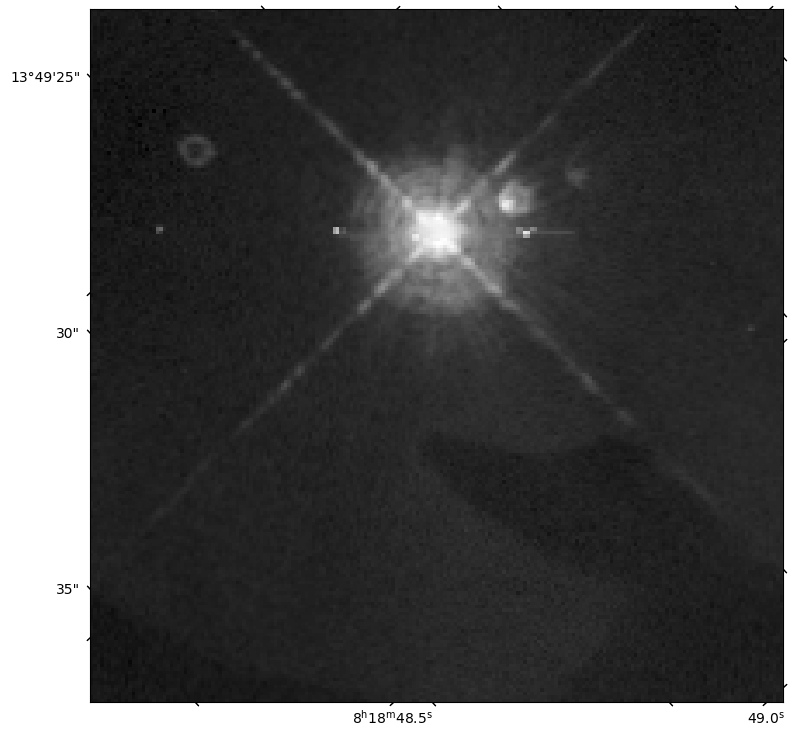

In [212]:
from astropy.convolution import Gaussian1DKernel
fig = plt.figure(figsize=(9,9))
fig.add_subplot(111, projection=wcs)

new_data = no_trim_log_data[300:500, 800:1000] 
sigma = 24.5
G = Gaussian1DKernel(sigma)
plt.imshow(new_data,cmap='gray')


In [221]:
fig = plt.figure(figsize=(6,6))
#star is in between 330 and 342
min=30
max=170

onerow=[]
logg_data=new_data[min:max]

for i in range(0,max-min):
    plt.figure(1)
    onerow.append(logg_data[i:i+1]) #one row at a time
    
    
rows = []
for i in range(0,max-min):
    rows.append(onerow[i][0]) #the extra [0] takes it out of an extra set of []

#ploww one row only (dont for get [] around row[i])


rowss,blurred=[],[]
for i in range(0,max-min):
    
    rowss.append(rows[i][min:max])
    
    plt.figure(1)
    plt.hist(rowss[i],label=i) #plot single rows seperately 
    plt.close()
    plt.figure(2)
    plt.plot(rowss[i])
    plt.close()


plt.figure(3)
d_matrix=[]
blurred=[]
for i in range(0,max-min):
    blurred.append(convolve_fft(rowss[i],G.array[min:max])) #the blured row
plt.plot(blurred,label=i) #the blurred one row of the image
#plt.imshow(blurred,cmap='gray')
plt.close()

In [214]:
GG = G.array[min:max] 
G_reverse= np.flip(GG) 

iteration = 0
G_arrs = []


#replace G with zeros for each| column. There always 500 columns. This lenght always remains the same. 
while iteration < max-min:
    G_reverse = np.where(G_reverse == G_reverse[iteration], 0, G_reverse) 
    iteration = iteration +1 
 
    G_arrs.append(G_reverse) 


iteration_running = 0
#note: this takes about 3 min to complete

while iteration_running < 1:
    
    iteration_running = iteration_running + 1

    blurred_new = blurred
    m=blurred

    eps=.001
    #regularizaiton matrix
    R = eps**2 * np.identity((max-min))

    
    res=[]
    for i in range(0,max-min):
        res.append(rowss[i]) 

    m=[]
    for i in range(0,max-min):
     
        gt= np.transpose(G_arrs)
        gtg= np.dot(gt,G_arrs)
        gtd=np.dot(gt,res[i])
        #inverse problem 
        mm = np.dot(np.linalg.inv(gtg+R),res[i])
        
        np.array(m.append(mm)) 
#     blurred=[]
#     for i in range(0,max-min):
    blurred = np.add(blurred_new,m)

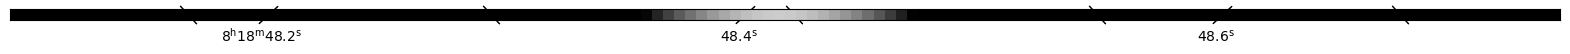

In [215]:
fig = plt.figure(1,figsize=(20,5)) 
fig.add_subplot(111, projection=wcs)
plt.imshow(blurred_new[100:101],cmap="gray",origin='lower',vmin=1.9,vmax=2)
plt.savefig('source_row.pdf',style='pdf')

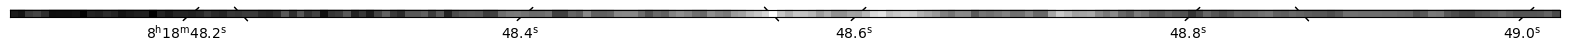

In [216]:
fig = plt.figure(1,figsize=(20,5)) 
fig.add_subplot(111, projection=wcs)
plt.imshow(new_data[100:101],cmap='gray')
#plt.savefig('OG_row.pdf',style='pdf')

/Users/candicestauffer/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


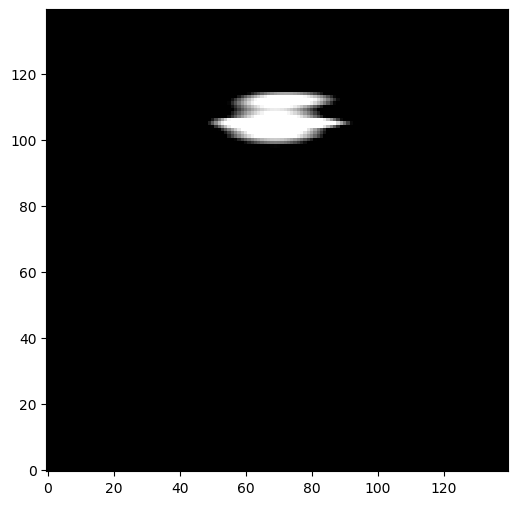

In [226]:
plt.figure(1,figsize=(6,6)) 
fig.add_subplot(111, projection=wcs)
plt.imshow(blurred_new,cmap="gray",origin='lower',vmin=1.9,vmax=2) 
x = np.linspace(min,max,len(m))


# plt.figure(2)
# plt.hist(rowss[i])
# plt.show()

/Users/candicestauffer/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


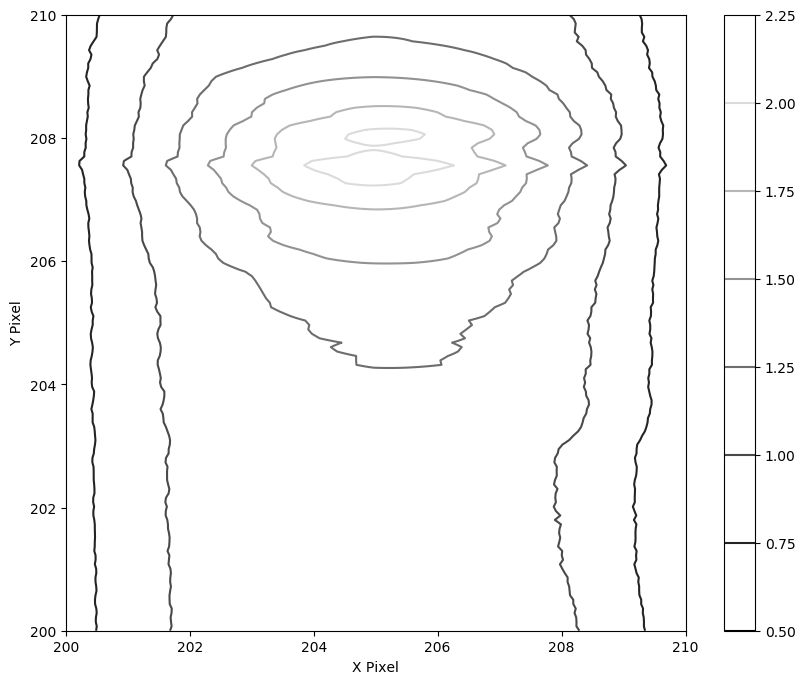

In [218]:
plt.figure(1,figsize=(10,8)) 
fig.add_subplot(111, projection=wcs)
ngrid=max-min
xgrid = np.linspace(200,210,ngrid)
ygrid = np.linspace(200,210,ngrid)

X,Y = np.meshgrid(xgrid,ygrid)

plt.contour(X,Y,blurred_new,cmap='gray') 
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.colorbar()
plt.savefig('contour.pdf',style='pdf')